In [1]:
#We import all necessary libraries.
import pandas as pd
from tqdm import tqdm; tqdm.pandas()
import re
import numpy as np
from collections import Counter
import Levenshtein
from nltk.tokenize import sent_tokenize
import joblib
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from scipy.stats import spearmanr
from itertools import zip_longest

In [2]:
#We read in the data.
df = pd.read_csv("52_micro_data.csv")

In [3]:
#We convert the retrieval time to a datetime object.
df["retrieval_time"] = pd.to_datetime(df.retrieval_time,  format="mixed", utc=True)

In [4]:
#We assess how long the scraping took place.
df.retrieval_time.max() - df.retrieval_time.min()

Timedelta('0 days 20:15:57.827447')

In [5]:
#We assess when it started.
df.retrieval_time.min()

Timestamp('2023-11-11 13:15:43.746295+0000', tz='UTC')

In [6]:
#We print the complete length.
print(len(df))

36215


## extra row filters

In [7]:
#We define a function to clean the body text.
def get_clean_text(x):
    
    lst = []
    #We first want to filter out any wrongly scraped content.
    #In this case we define a list of sentences with promotional content, such as to take subscriptions.
    flter = ["Na de gekozen periode kunt u maandelijks opzeggen", 
             "Door mijn rekeningnummer in te vullen", 
             "Log in of maak een account aan"]
    
    #We first check if the value is correctly stored as a list.
    if isinstance(x, str):
        x = eval(x)
    else:
        pass
    
    #If so we loop over the paragraphs in the list of texts.
    for item in x:
        #We check if any of the filter items is present in the text.
        if not any(f in item for f in flter):
            #Furterhmore we replace all faulty symbols by simply empty spaces.
            result = item.replace("\\", " ").replace("\n", " ").replace("\t", " ")
            #If more then one space after each other exist, we replace it by a single space.
            result = re.sub(r" +", " ", result)
            #If we end up with NOT an empty string, we append it to the result list.
            if result != "":
                lst.append(result)
            else:
                pass
        else:
            pass
    #We return the list.
    return lst

#We also create a function to combine the paragraphs into one piece of string.
def get_text_one(x): 
    #If there is only one paragraph we simply store the first element of the list.
    if len(x) == 1:
        x = x[0]
    else:
        #In any other case we join the paragraphs by single spaces.
        x = " ".join(x)
    #We return our result.
    return x

In [8]:
#We remove all irrelevant links.
df = df[~df["links"].str.contains("live|podcast|sudoku|in-het-midden|scrypto|nieuwsbrieven")]; print(len(df))

35587


In [9]:
#We drop all rows with too many missing values.
threshold = 2; df = df.dropna(thresh=len(df.columns) - threshold); print(len(df))

32965


In [10]:
#We apply the text clean function.
df["txt_text_clean"] = df.txt_text.progress_apply(lambda x: get_clean_text(x))

100%|██████████████████████████████████████████████████████████████████████████| 32965/32965 [00:05<00:00, 5683.83it/s]


In [11]:
#We combine the cleaned text into one text.
df["txt_text_one"] = df.txt_text_clean.progress_apply(lambda x: get_text_one(x))

100%|████████████████████████████████████████████████████████████████████████| 32965/32965 [00:00<00:00, 226503.90it/s]


In [12]:
#We exclude articles with no text at all.
df = df[df.txt_text_one != ""]; print(len(df))

32381


In [13]:
#We calculate the text length.
df["text_length"] = df.txt_text_one.progress_apply(lambda x: len(str(x)))

100%|███████████████████████████████████████████████████████████████████████| 32381/32381 [00:00<00:00, 1191805.38it/s]


In [14]:
#We calculate the mean of text length plus three times the standard deviation.
txt_length_max = round(np.mean(df.text_length) + 3*np.std(df.text_length)); print(txt_length_max)

28491


In [15]:
#We remove all texts that are too long.
df = df[df.text_length < txt_length_max]; print(len(df))

32251


In [16]:
#We remove possible duplicates.                       
df = df.groupby(["iteration"]).progress_apply(lambda group: group.drop_duplicates(subset="links")).reset_index(drop=True);print(len(df))

100%|█████████████████████████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 814.28it/s]

32251


## processing

### news_source

In [17]:
#We extract the news source by the stem of the websites.
df["news_source"] = df.links.progress_apply(lambda x : re.search(r"www\.(.+)\.nl", x).group(1))

100%|████████████████████████████████████████████████████████████████████████| 32251/32251 [00:00<00:00, 428427.77it/s]


In [18]:
#We assess whether the text contains an error disclosure.
def get_error_correction_sentence(text, max_distance=20):
    text = str(text).strip().lower()
    #We turn the text in sentences.
    sentences = sent_tokenize(text)
    pattern = f"\\b(eerder|vorig).{{0,{max_distance}}}\\b(versie|publicatie|bericht\\b)|\\b(versie|publicatie).{{0,{max_distance}}}\\b(eerder|vorig)"
    hits = []
    #For each sentence we look if it matches our regular expression.
    #We namely thus test whether a sentence contains earlier and version, or synonyms, within a range of 20 words.
    for sen in sentences:
        #If found we append the sentence to a list.
        result = re.search(pattern, string=sen)
        if result:
            hits.append(sen)
        else:
            pass
    return hits

In [19]:
#We use the above function on our data.
df["error_cor_sen"] = df.txt_text.progress_apply(lambda x: get_error_correction_sentence(x))

100%|██████████████████████████████████████████████████████████████████████████| 32251/32251 [00:19<00:00, 1654.55it/s]


### peak hours

In [20]:
#We convert the publication date to an actual datetime object.
df["datePublished"] = pd.to_datetime(df.datePublished,  format="mixed", utc=True)

In [21]:
#We extract the publication hour.
df["pub_hour"] = df.datePublished.dt.hour

In [22]:
#We purely focus on the unique links.
df_unique = df[["links", "pub_hour"]].drop_duplicates()

<Axes: >

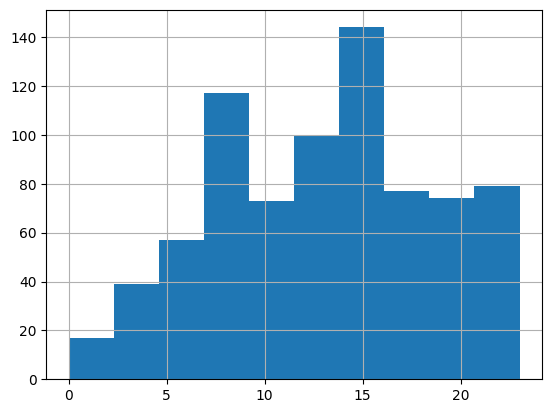

In [23]:
#We plot the publication hour distribution.
df_unique["pub_hour"].hist()

In [24]:
#We calculate the median hour based on its amount of publications.
pub_hour_median = df_unique["pub_hour"].value_counts(sort=True).median()

In [25]:
#We create a dictionary in which for each hour of the day we store whether it is an hour with an above amount of publications.
pub_hour_dict = dict(df_unique["pub_hour"].value_counts(sort=True) > pub_hour_median)

In [26]:
#We define a function to loop over the above defined dictionary.
def get_peak_hour(x, dist=pub_hour_dict):
    #Namely we loop over the dictionary until we find the hour of the publication.
    #And then we send back the value that is related to it.
    for key, value in dist.items():
        if x == key:
            return value
            break
        else:
            continue

In [27]:
#We use the function to create a new column.
df["peak_hour"] = df.pub_hour.progress_apply(lambda x: get_peak_hour(x))

100%|████████████████████████████████████████████████████████████████████████| 32251/32251 [00:00<00:00, 694692.37it/s]


### numbers

In [28]:
#We try to find all numbers in the body of the text.
df["numbers_in_text"] = df.txt_text_one.progress_apply(lambda x: re.findall(r"\d+", x))

100%|█████████████████████████████████████████████████████████████████████████| 32251/32251 [00:01<00:00, 19182.39it/s]


In [29]:
df.numbers_in_text

0                                               [27, 2016]
1        [6, 2, 6, 3, 27, 24, 218, 3, 2, 6, 2, 2, 0, 3,...
2                             [36, 4, 2, 321, 4, 4, 2, 36]
3                                                       []
4                                                      [1]
                               ...                        
32246    [250, 000, 0, 15, 19, 2016, 1, 2019, 4, 37, 00...
32247                               [14, 00, 20, 30, 2018]
32248                                                  [1]
32249    [5, 000, 28, 6, 10, 99, 6, 13, 01, 500, 1, 000...
32250                         [3, 18, 1990, 125, 130, 246]
Name: numbers_in_text, Length: 32251, dtype: object

### changes

In [30]:
#We create a column keeping track per article link, how often it has been iterated.
df["iter_since_pub"] = df.groupby("links").cumcount() + 1

In [31]:
#Sometimes scraping appeared faulty.
#Namely in some iterations a page could be fully loaded, while in others it would not be fully loaded.
#This gave the impression that the body changed, while in reality, scraping was unstable.
#We therefore define a function to assess whether scraping was succesfull.
def assess_scrape_success(group):
    #We firstly assess how big the change was if it is there.
    group["change_length"] = group["text_length"].shift() - group["text_length"]
    #We also assess what the length is of the introduction.
    group["intro_length"] = group.txt_text_clean.apply(lambda x: len(x[0]))
    #Specifcally for nrc there was sometimes an additional text of promotion.
    group["tmp_column"] = group.apply(lambda row: bool(re.search(r"\s\bVolg\b\s.*", row["txt_text_one"])) and row["news_source"] == "nrc", axis=1)
    
    #We have a few conditions which were indicative of faulty scraping.
    #Namely if the text length was simply based on the change of text length plus the intro length.
    #This would indicate that the change is purely on the basis that sometimes the intro was scraped, and sometimes it was not.
    #ADdditionally we check for the specific NRC mistake of sometimes having extra promotional text.
    conditions = [(group["intro_length"] + abs(group["change_length"]) != group["text_length"]) &
                  (group["intro_length"] + abs(group["change_length"]) != group["text_length"].shift(1)) &
                  (group["intro_length"] + abs(group["change_length"]) != group["text_length"].shift(-1)),
                  (group["tmp_column"] == True)]
    
    choices = ["yes", "follow_error"]
    
    #We return yes if it meets the first conditions.
    #We return follow error if it matches the second condition.
    #In all other cases we return no.
    group["scrape_success"] = np.select(conditions, choices, default="no")
    
    group.drop(columns=["tmp_column"], inplace=True)
    
    return group

In [32]:
#We use the function on the links.
df = df.groupby("links").progress_apply(assess_scrape_success).reset_index(level=0, drop=True)

100%|███████████████████████████████████████████████████████████████████████████████| 750/750 [00:03<00:00, 212.46it/s]


In [33]:
Counter(df.scrape_success)

Counter({'yes': 22703, 'no': 5547, 'follow_error': 4001})

In [34]:
#We only keep the cases which were successfully scraped.
df_success = df[(df.scrape_success == "yes")]

In [35]:
#We define a function to assess whether the date tags have changed.
def assess_meta_change(group):
    
    #In the case that the dateModified tag is empty we assume that it remained unchanged.
    #We therefore fill it simply with the publication date.
    group["dateModified"] = group["dateModified"].fillna(group["datePublished"])
    
    #The first condition assesses whether both have changed.
    #The second condition checks whether solely the publication date changed.
    #The third does so for the modification date.
    #The last one checks whether both remained the same.
    conditions = [(group["datePublished"] != group["datePublished"].shift()) & (group["dateModified"] != group["dateModified"].shift()).iloc[1:], 
                  (group["datePublished"] != group["datePublished"].shift()) & (group["dateModified"] == group["dateModified"].shift()).iloc[1:], 
                  (group["datePublished"] == group["datePublished"].shift()) & (group["dateModified"] != group["dateModified"].shift()).iloc[1:],  
                  (group["datePublished"] == group["datePublished"].shift()) & (group["dateModified"] == group["dateModified"].shift()).iloc[1:]]
    
    #We return the respective choices to the conditions.
    choices = ["both", "pub", "mod", "none"]

    group["meta_change"] = np.select(conditions, choices, default="missing")
    
    return group

In [36]:
#We also assessed whether elements in the text changed.
def assess_article_change(group):
    
    #We firstly define a column with the initial article length.
    group["initial_length"] = group["text_length"].iloc[0]
    #We also define a column with the original count of numbers in text.
    group["initial_n_numbers_in_text"] = len(group["numbers_in_text"].iloc[0])
    #We limit the numbers in text to the length of the initial amount of numbers in text.
    #In doing so we truly try to compare the same numbers.
    group["numbers_in_text"] = group["numbers_in_text"][:len(group["initial_n_numbers_in_text"])]
    #We assess how many characters were added or removed.
    group["change_length"] = group["text_length"].shift() - group["text_length"]
    #We also transform this change to its direction.
    group["change_direction"] = np.sign(group["change_length"])
    #We create a column for the second text of the pair.
    group["txt_text_one_shift"] = group.groupby("links")["txt_text_one"].shift()
    #We assess how many character changes are needed to come to the same texts.
    group["change_size"] = group.apply(lambda row: Levenshtein.distance(str(row["txt_text_one"]), str(row["txt_text_one_shift"])), axis=1)
    #We assess whether the initial numbers in text remained the same.
    group["initial_numbers_change"] = group["numbers_in_text"] != group["numbers_in_text"].shift()
    
    #We define four conditions: did both the headline and body change, did solely the headline change, the body changed, or did nothing changed.    
    conditions = [(group["headline"] != group["headline"].shift()) & (group["txt_text_one"] != group["txt_text_one"].shift()).iloc[1:], 
                  (group["headline"] != group["headline"].shift()) & (group["txt_text_one"] == group["txt_text_one"].shift()).iloc[1:], 
                  (group["headline"] == group["headline"].shift()) & (group["txt_text_one"] != group["txt_text_one"].shift()).iloc[1:],  
                  (group["headline"] == group["headline"].shift()) & (group["txt_text_one"] == group["txt_text_one"].shift()).iloc[1:]]
    
    #We return the corresponding answers.
    choices = ["both", "head", "text", "none"]

    group["article_change"] = np.select(conditions, choices, default="missing")
    
    group.drop(columns=["txt_text_one_shift"], inplace=True)

    return group

In [37]:
#We apply the meta change function.
df_success = df_success.groupby("links").progress_apply(assess_meta_change).reset_index(level=0, drop=True)

100%|███████████████████████████████████████████████████████████████████████████████| 750/750 [00:02<00:00, 270.13it/s]


In [213]:
Counter(df_success.meta_change)

Counter({'none': 21593, 'missing': 750, 'mod': 331, 'both': 29})

In [38]:
#We apply the article change function.
df_success = df_success.groupby("links").progress_apply(assess_article_change).reset_index(level=0, drop=True)

100%|███████████████████████████████████████████████████████████████████████████████| 750/750 [00:04<00:00, 157.72it/s]


In [39]:
Counter(df_success.article_change)

Counter({'none': 21529, 'missing': 750, 'text': 313, 'both': 66, 'head': 45})

In [40]:
#We create a function to assess whether changes were disclosed.
def assess_error_disclosure(group):
     
    #It could either be that the timestamps changed.
    #Or it could be that the error correction sentences were changed.
    conditions = [(group["txt_timestamps"].astype(str) != group["txt_timestamps"].astype(str).shift()) & (group.index != group.index[0]),
                  (group["error_cor_sen"].astype(str) != group["error_cor_sen"].astype(str).shift()) & (group.index != group.index[0])]
    
    #We return the corresponding answers.
    #In the case that both did not change, we just return none.
    choices = ["timestamp", "text"]

    group["error_disclosure"] = np.select(conditions, choices, default="none")

    return group

In [41]:
#We apply the above defined function.
df_success = df_success.groupby("links").progress_apply(assess_error_disclosure).reset_index(level=0, drop=True)

100%|███████████████████████████████████████████████████████████████████████████████| 750/750 [00:01<00:00, 732.15it/s]


In [42]:
#We create a function to assess how prominent the change was.
def get_change_prominence(A, B):
    A = str(A); B = str(B)
    index = 0
    #We do so by iterating over the characters for both texts.
    for i, (lA, lB) in enumerate(zip_longest(A, B, fillvalue=None)):
        match = lA == lB
        #When we find a mismatch between the characters, we store the index of the mismatch.
        #We then divide the index by the total lenght of the initial text.
        #We return this score.
        if not match:
            mismatch = i 
            prominence = 1 - (i / len(A))
            return prominence
            break
        index += 1
    return "end"

In [43]:
#We create a column for every subsequent text.
df_success["txt_text_one_B"] = df_success.groupby("links").txt_text_one.shift()

In [44]:
#We calculate the prominence of change.
df_success["prominence_factor"] = df_success.progress_apply(lambda x: get_change_prominence(A=x["txt_text_one"], B=x["txt_text_one_B"]), axis=1)

100%|██████████████████████████████████████████████████████████████████████████| 22703/22703 [00:06<00:00, 3663.72it/s]


In [49]:
#We only keep the articles that changed in text.
df_changed = df_success[(df_success.article_change == "text")]

### features

In [50]:
#We create a dummy to assess disclosure.
def get_tp_error_disclosure_dummy(x):
    #If there is no disclosure at all we return 0.
    #Otherwise we return 1.
    if x == "none":
        return 0
    else:
        return 1

In [53]:
#We add it as a column.
df_changed["tp_error_disclosure_dum"] = df_changed.error_disclosure.progress_apply(lambda x: get_tp_error_disclosure_dummy(x))

100%|████████████████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 611465.84it/s]
C:\Users\dubel\AppData\Local\Temp\ipykernel_16728\2866211869.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_changed["tp_error_disclosure_dum"] = df_changed.error_disclosure.progress_apply(lambda x: get_tp_error_disclosure_dummy(x))


In [54]:
#We assess how many article changes were disclosed.
round(df_changed.tp_error_disclosure_dum.mean(), 2)

0.48

In [55]:
#We load in the softness vectorizer and classifier.
vectorizer = joblib.load("52_softness_vectorizer.joblib")
nb = joblib.load("52_softness_classifier.joblib")

In [56]:
#We used the vectorizer and classifier the predict the softness of the news articles.
def predict_softness(x, nb=nb):
    y = nb.predict(vectorizer.transform([x]))[0]
    if y == 0:
        return "soft"
    elif y == 1:
        return "hard"

In [57]:
df_changed["p_article_softness"] = df_changed.txt_text_one.progress_apply(lambda x: predict_softness(x))

100%|██████████████████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 1059.42it/s]
C:\Users\dubel\AppData\Local\Temp\ipykernel_16728\665770249.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_changed["p_article_softness"] = df_changed.txt_text_one.progress_apply(lambda x: predict_softness(x))


In [58]:
Counter(df_changed.p_article_softness)

Counter({'hard': 186, 'soft': 127})

In [59]:
Counter(df_changed.change_direction)

Counter({-1.0: 195, 1.0: 102, 0.0: 16})

## analysis

In [60]:
#We assess how many unique articles are in the entire data.
n_articles = len(pd.unique(df.links.values)); print(n_articles)

750


In [61]:
#We assessed how many articles changed atleast once.
n_changed_once = len(df_changed.groupby("links")); n_changed_once

172

In [62]:
#We calculate how many changed percentage wise.
round(n_changed_once / n_articles * 100, 2)

22.93

In [63]:
#We asses how many changes there were in total.
n_changed = len(df_changed); print(n_changed)

313


In [64]:
#We assess how many were disclosed.
round(df_changed.tp_error_disclosure_dum.mean(),2)

0.48

In [65]:
Counter(df_changed.error_disclosure)

Counter({'none': 162, 'timestamp': 150, 'text': 1})

In [67]:
#We calculate the changes per outlet.
df_changed.groupby("news_source").size()

news_source
ad            67
nos           48
nrc           82
nu            78
telegraaf     32
volkskrant     6
dtype: int64

In [68]:
#We make sure that the prominence factor is read as a float.
df_changed["prominence_factor"] = df_changed.prominence_factor.astype(float)

C:\Users\dubel\AppData\Local\Temp\ipykernel_16728\3131193607.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_changed["prominence_factor"] = df_changed.prominence_factor.astype(float)


<Axes: >

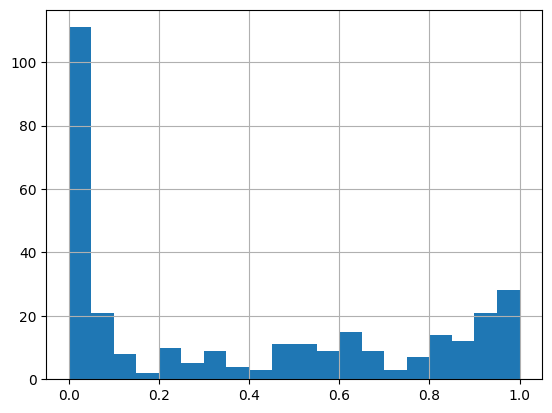

In [70]:
#We calculate its distribution.
df_changed.prominence_factor.hist(bins=20)

In [71]:
Counter(df_changed.initial_numbers_change)

Counter({True: 211, False: 102})

In [72]:
#We define our predictors.
predictors = "change_size + change_direction + initial_numbers_change + prominence_factor + C(p_article_softness, Treatment(reference='soft')) + peak_hour + initial_length + initial_n_numbers_in_text + iter_since_pub"

In [73]:
#We create a function to perform the analysis.
def get_output(y="tp_error_disclosure_dum", x=predictors):
    #We namely define a logistic regression function.
    md = smf.logit(f"{y} ~ {x}", df_changed)
    #We fit the model and return the summary.
    mdf = md.fit()
    summary = mdf.summary()
    #We extract the coefficients.
    coef_table = summary.tables[1]
    #We convert it to a dataframe.
    coef_data = pd.DataFrame(coef_table.data, columns=coef_table.data[0])
    coef_data = coef_data.drop(0)
    
    #We extract the statistics we need.
    coef_data = coef_data[["coef", "std err", "P>|z|"]]
    #We define a new column with readable names for all our predictors.
    coef_data["feature"] = ["Intercept", "initial numbers changed [yes]", "article type [hard]", "peak hour [yes]",
                            "change size", "change direction", "change prominence", "initial length", 
                            "initial n numbers", "iterations since publication"]
     
    #We set the feature name as our index.
    coef_data.set_index("feature", inplace=True)    
    coef_data.index.name=None
    #We rename the statistics columns.
    coef_data.rename(columns={"coef":"$B$", "std err":"$se$", "P>|z|":"$p$"}, inplace=True)
    #We round some of the columns.
    coef_data[["$B$", "$se$"]] = coef_data[["$B$", "$se$"]].astype(float).apply(lambda x: round(x, 2))
    
    #We print the summary, and the latex table.
    print(coef_data.to_latex(float_format="%.2f"))
    print(summary)
    #We extract some model summary statistics.
    print(f"$N = {round(mdf.nobs)}, \chi^2 ({mdf.df_model}, {mdf.df_resid}) = {round((mdf.llnull - mdf.llf) * -2, 2)}, pseudo$-$R^2 = {round(mdf.prsquared,2)}.$")
    return coef_data

In [74]:
get_output()

Optimization terminated successfully.
         Current function value: 0.496325
         Iterations 6
\begin{tabular}{lrrl}
\toprule
 & $B$ & $se$ & $p$ \\
\midrule
Intercept & 0.12 & 0.52 &  0.821 \\
initial numbers changed [yes] & -0.82 & 0.34 &  0.014 \\
article type [hard] & -0.29 & 0.33 &  0.373 \\
peak hour [yes] & 0.65 & 0.31 &  0.035 \\
change size & -0.00 & 0.00 &  0.016 \\
change direction & -0.21 & 0.17 &  0.204 \\
change prominence & 2.18 & 0.48 &  0.000 \\
initial length & -0.00 & 0.00 &  0.000 \\
initial n numbers & 0.02 & 0.01 &  0.266 \\
iterations since publication & -0.00 & 0.01 &  0.968 \\
\bottomrule
\end{tabular}

                              Logit Regression Results                             
Dep. Variable:     tp_error_disclosure_dum   No. Observations:                  313
Model:                               Logit   Df Residuals:                      303
Method:                                MLE   Df Model:                            9
Date:                

,$B$,$se$,$p$
Intercept,0.12,0.52,0.821
initial numbers changed [yes],-0.82,0.34,0.014
article type [hard],-0.29,0.33,0.373
peak hour [yes],0.65,0.31,0.035
change size,-0.00,0.00,0.016
change direction,-0.21,0.17,0.204
change prominence,2.18,0.48,0.000
initial length,-0.00,0.00,0.000
initial n numbers,0.02,0.01,0.266
iterations since publication,-0.00,0.01,0.968
